In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [137]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn import cluster, mixture
from sklearn.metrics import consensus_score

In [135]:
import simplejson

In [136]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

In [5]:
#loading credentials
with open("spotifywerk.json") as fh:
    creds = simplejson.loads(fh.read())


In [6]:
cid = creds['client_id']
csecret = creds['secret']

In [7]:
uid='jesjes354'

In [8]:
#https://towardsdatascience.com/playlist-classification-on-spotify-using-knn-and-naive-bayes-classification-35a279b7e255

client_credentials_manager = SpotifyClientCredentials(client_id=cid, 
                                                      client_secret=csecret) 
scope = 'user-top-read'
redirect_uri="https://github.com/jessimk"
try:
    token = util.prompt_for_user_token(uid, scope, 
                                       client_id=cid, 
                                       client_secret=csecret, 
                                       redirect_uri=redirect_uri)  
    sp=spotipy.Spotify(auth= token)
except:
    print('Token is not accesible for ' + uid)

In [9]:
current_playlists = sp.current_user_playlists(limit=50, offset=0)

In [10]:
playlist_list_names = []
playlist_list_ids = []

for i, playlists in enumerate(current_playlists['items']):
    playlist_list_names.append(playlists['name'])
    playlist_list_ids.append(playlists['id'])

In [11]:
playlist_names_ids = dict(zip(playlist_list_names, playlist_list_ids))


In [12]:
playlist_names_ids

{'Running music': '2wtefKQXJnhl6Wa2tFf5OH',
 'Hunnybee': '1koYjrm28MXy50bLBp5WDq',
 "Papi's iPod": '5Ueufhk4hfXTHxtuxg4ptP'}

In [13]:
playlist_tracks = sp.playlist_tracks(playlist_names_ids['Hunnybee'], fields=None, limit=100, offset=0, market=None)

In [14]:
playlist_tracks['items'][0]

{'added_at': '2019-12-01T01:06:32Z',
 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/jesjes354'},
  'href': 'https://api.spotify.com/v1/users/jesjes354',
  'id': 'jesjes354',
  'type': 'user',
  'uri': 'spotify:user:jesjes354'},
 'is_local': False,
 'primary_color': None,
 'track': {'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5xeBMeW0YzWIXSVzAxhM8O'},
     'href': 'https://api.spotify.com/v1/artists/5xeBMeW0YzWIXSVzAxhM8O',
     'id': '5xeBMeW0YzWIXSVzAxhM8O',
     'name': 'of Montreal',
     'type': 'artist',
     'uri': 'spotify:artist:5xeBMeW0YzWIXSVzAxhM8O'}],
   'available_markets': ['AD',
    'AE',
    'AR',
    'AT',
    'AU',
    'BE',
    'BG',
    'BH',
    'BO',
    'BR',
    'CA',
    'CH',
    'CL',
    'CO',
    'CR',
    'CY',
    'CZ',
    'DE',
    'DK',
    'DO',
    'DZ',
    'EC',
    'EE',
    'EG',
    'ES',
    'FI',
    'FR',
    'GB',
    'GR',
    'GT',
    'HK',
    '

In [15]:
playlist_tracks['items'][0]['track']['id']

'3X8gOyVXP93Tslnz9Bxw24'

In [16]:
track_ids = []
for number, track in enumerate(playlist_tracks['items']):
    track_ids.append(track['track']['id'])

In [17]:
track_features = pd.DataFrame.from_dict(sp.audio_features(track_ids))

In [18]:
df = []
for track_id in track_ids:
    track_info = sp.track(track_id)
    
    row = [track_id, 
               track_info['name'], 
               track_info['artists'][0]['name'], 
               track_info['popularity'], 
               track_info['album']['release_date'],
               track_info['explicit']
          ]
    
    df.append(row)
    row = []
    
track_data = pd.DataFrame(df, columns = ['id', 'name', 'artist', 'popularity', 'album_release_dt', 'explicit'])

In [19]:
playlist_track_data = pd.merge(track_data, track_features, on='id')

In [20]:
playlist_track_data.columns

Index(['id', 'name', 'artist', 'popularity', 'album_release_dt', 'explicit',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [21]:
playlist_track_data.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,51.041667,0.669236,0.647986,5.416667,-7.564764,0.527778,0.067247,0.178320,0.201033,0.173707,0.548451,120.507056,246711.458333,3.972222
std,17.605567,0.173025,0.165909,3.888408,2.162624,0.502731,0.048172,0.234723,0.311017,0.123409,0.228009,22.289665,64815.655407,0.374249
min,3.000000,0.259000,0.251000,0.000000,-12.418000,0.000000,0.026200,0.000342,0.000000,0.023300,0.045800,73.998000,137600.000000,1.000000
25%,45.250000,0.555000,0.522750,1.000000,-8.987750,0.000000,0.036650,0.017575,0.000295,0.099025,0.411250,109.224000,201732.750000,4.000000
50%,53.000000,0.687000,0.669500,6.500000,-7.329000,1.000000,0.051050,0.067850,0.004685,0.121000,0.569500,119.464500,225433.000000,4.000000
75%,60.250000,0.803250,0.784000,8.000000,-5.937250,1.000000,0.079575,0.219750,0.332000,0.220000,0.734250,126.048500,287587.750000,4.000000
max,97.000000,0.975000,0.927000,11.000000,-3.240000,1.000000,0.284000,0.873000,0.972000,0.648000,0.966000,183.241000,436237.000000,5.000000


In [22]:
playlist_track_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 0 to 71
Data columns (total 23 columns):
id                  72 non-null object
name                72 non-null object
artist              72 non-null object
popularity          72 non-null int64
album_release_dt    72 non-null object
explicit            72 non-null bool
danceability        72 non-null float64
energy              72 non-null float64
key                 72 non-null int64
loudness            72 non-null float64
mode                72 non-null int64
speechiness         72 non-null float64
acousticness        72 non-null float64
instrumentalness    72 non-null float64
liveness            72 non-null float64
valence             72 non-null float64
tempo               72 non-null float64
type                72 non-null object
uri                 72 non-null object
track_href          72 non-null object
analysis_url        72 non-null object
duration_ms         72 non-null int64
time_signature      72 non-null int6

In [23]:
features_to_plot = playlist_track_data.drop(columns=['id', 'name', 'artist','album_release_dt','type', 'explicit','uri', 'track_href', 'analysis_url'],axis=1)

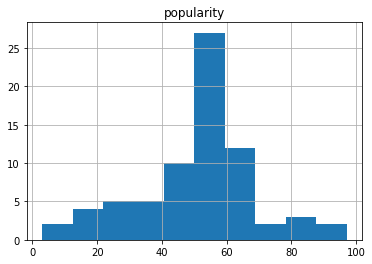

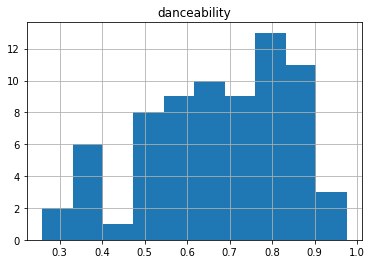

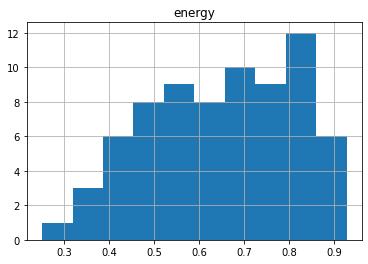

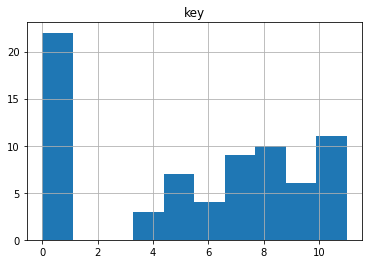

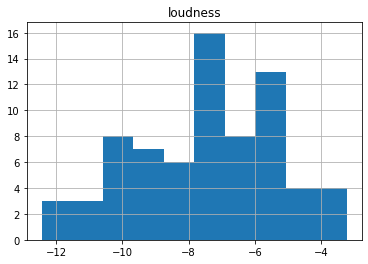

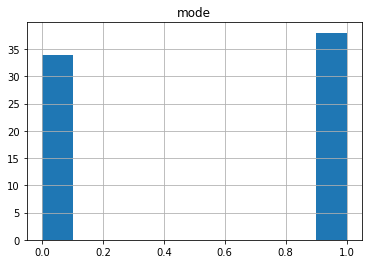

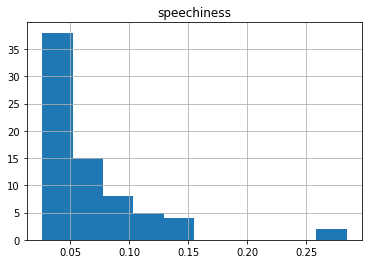

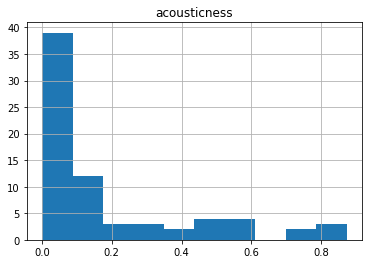

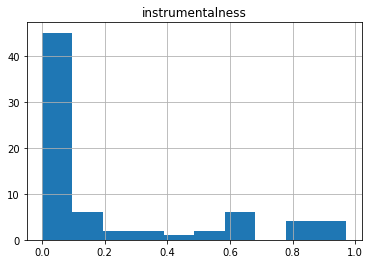

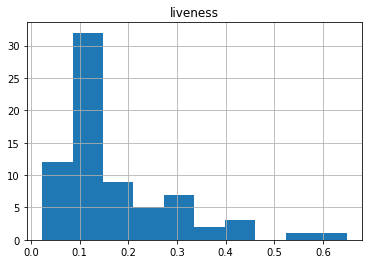

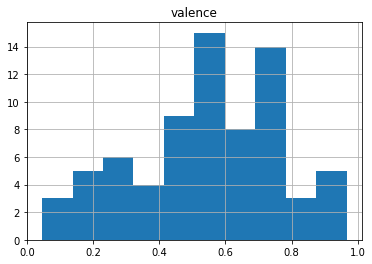

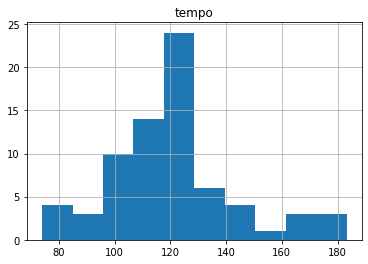

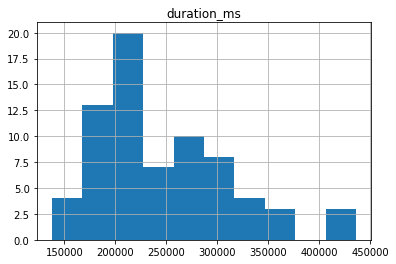

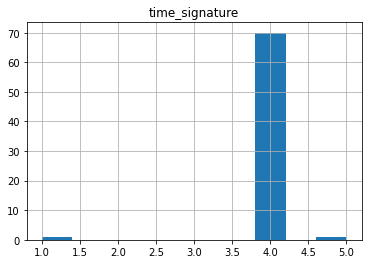

In [24]:
for feature in features_to_plot.columns:
    plt.figure()
    plt.title(feature)
    features_to_plot[feature].hist()

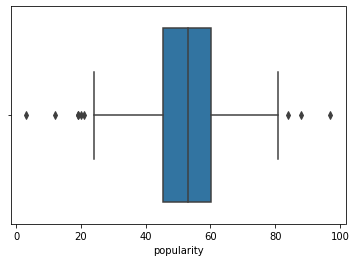

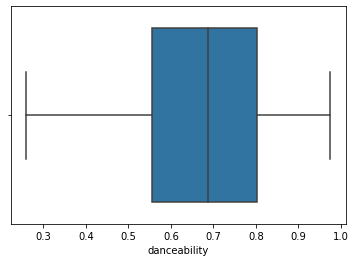

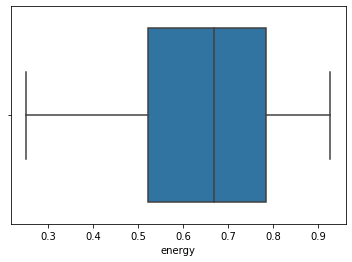

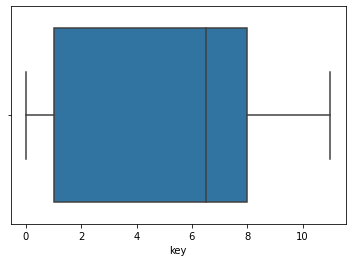

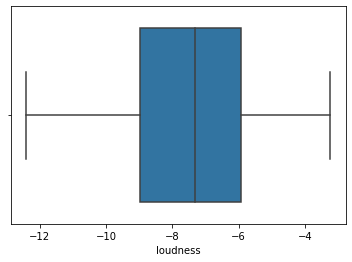

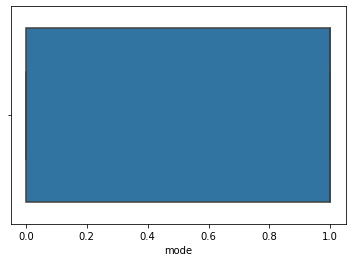

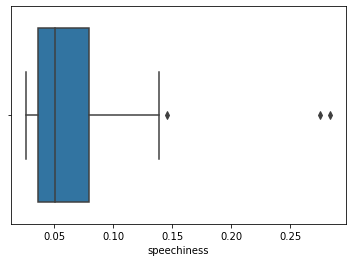

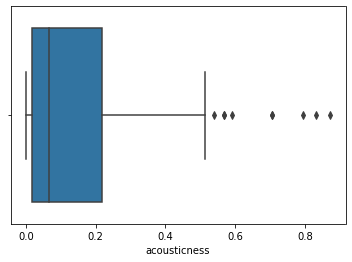

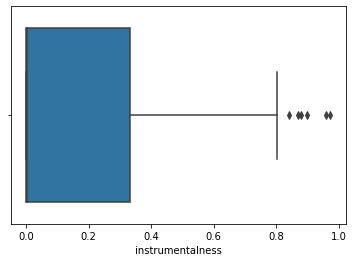

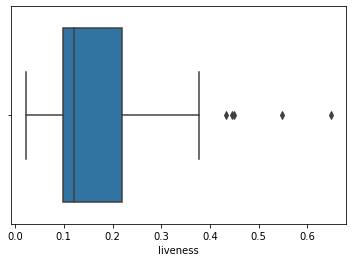

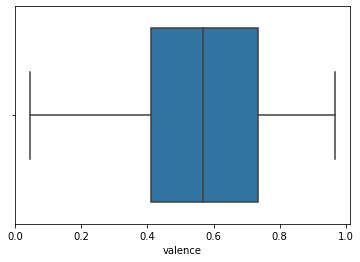

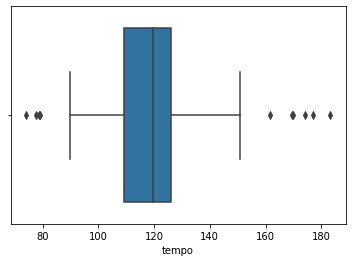

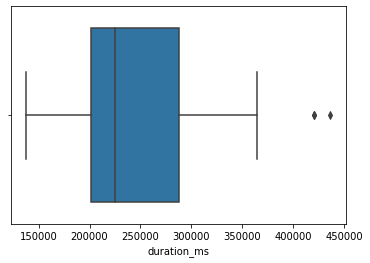

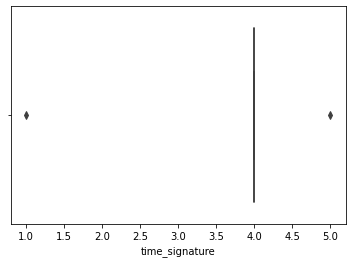

In [25]:
for feature in features_to_plot.columns:
    plt.figure()
    sns.boxplot(feature, data=features_to_plot)

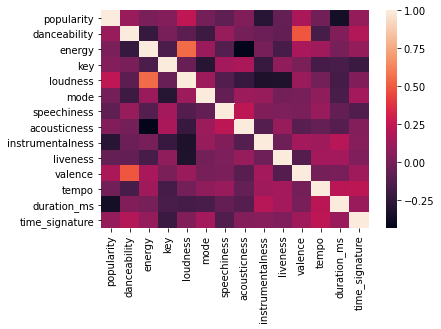

In [26]:
sns.heatmap(features_to_plot.corr())

In [32]:
values = features_to_plot.mean().values.flatten().tolist()
values

[51.041666666666664,
 0.6692361111111111,
 0.6479861111111109,
 5.416666666666667,
 -7.564763888888889,
 0.5277777777777778,
 0.06724722222222222,
 0.17831995833333336,
 0.20103281750000002,
 0.17370694444444448,
 0.5484513888888889,
 120.50705555555558,
 246711.45833333334,
 3.9722222222222223]

In [33]:
categories = list(features_to_plot)
categories

['popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature']

In [44]:
spoticluster.describe()

,valence,speechiness,instrumentalness,tempo,energy,key
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.548451,0.067247,0.201033,120.507056,0.647986,5.416667
std,0.228009,0.048172,0.311017,22.289665,0.165909,3.888408
min,0.045800,0.026200,0.000000,73.998000,0.251000,0.000000
25%,0.411250,0.036650,0.000295,109.224000,0.522750,1.000000
50%,0.569500,0.051050,0.004685,119.464500,0.669500,6.500000
75%,0.734250,0.079575,0.332000,126.048500,0.784000,8.000000
max,0.966000,0.284000,0.972000,183.241000,0.927000,11.000000


In [49]:
spoticluster = features_to_plot[['valence', 'speechiness',
                                'instrumentalness', 
                                'tempo', 'energy', 'key']] 

scaler = preprocessing.MinMaxScaler()

scaled_data = spoticluster
scaled_data[['tempo', 'key']] = scaler.fit_transform(scaled_data[['tempo', 'key']])

/Users/jes/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jes/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [50]:
scaled_data.describe()

,valence,speechiness,instrumentalness,tempo,energy,key
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.548451,0.067247,0.201033,0.425739,0.647986,0.492424
std,0.228009,0.048172,0.311017,0.204037,0.165909,0.353492
min,0.045800,0.026200,0.000000,0.000000,0.251000,0.000000
25%,0.411250,0.036650,0.000295,0.322455,0.522750,0.090909
50%,0.569500,0.051050,0.004685,0.416196,0.669500,0.590909
75%,0.734250,0.079575,0.332000,0.476465,0.784000,0.727273
max,0.966000,0.284000,0.972000,1.000000,0.927000,1.000000


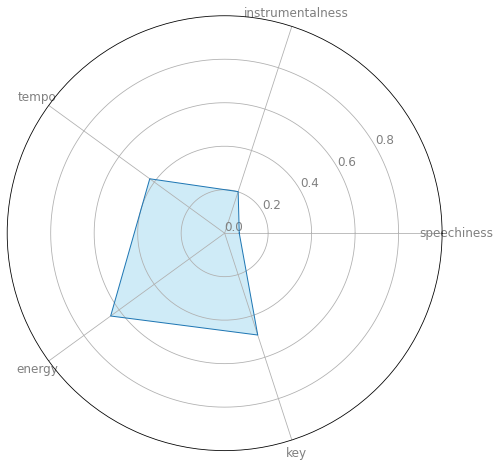

In [55]:
#https://jingwen-z.github.io/data-viz-with-matplotlib-series8-radar-chart/

values = scaled_data.mean().values.flatten().tolist()[1:]
values += values[:1] # repeat the first value to close the circular graph

categories = list(scaled_data)[1:]
angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
angles += angles[:1]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                       subplot_kw=dict(polar=True))

plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(np.arange(0, 1, 0.2), ['0.0','0.2', '0.4', '0.6', '0.8', '1.0'],
           color='grey', size=12)
plt.ylim(0, 1)
ax.set_rlabel_position(30)
 
ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.fill(angles, values, 'skyblue', alpha=0.4)

plt.show()

### DBSCAN

In [58]:
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
neighbs = NearestNeighbors(n_neighbors=2)
nbrs = neighbs.fit(scaled_data)

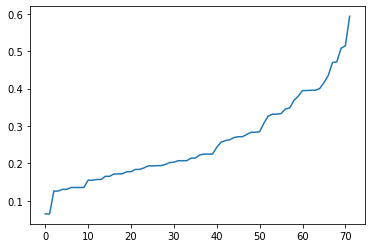

In [59]:
distances, indices = nbrs.kneighbors(scaled_data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [123]:
db = DBSCAN(eps=0.38, min_samples=2).fit(spoticluster)
labels = db.labels_

playlist_track_data['clusters'] = labels

In [124]:
labels

array([ 0,  1,  0,  2,  0,  0,  0,  3,  0, -1,  0,  0,  0,  0,  2,  3,  2,
       -1, -1, -1,  2,  0,  0,  0,  0, -1,  0,  2,  2,  0,  2,  2,  2,  0,
        0,  0,  0,  2,  0,  0,  0, -1,  1,  0, -1,  2,  2,  2, -1,  0,  0,
       -1, -1, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  2,  0,  2,  0,  0,
        0,  0,  2,  2])

In [125]:
pd.DataFrame(labels, columns=['labels'])['labels'].value_counts()

 0    39
 2    17
-1    12
 3     2
 1     2
Name: labels, dtype: int64

In [126]:
playlist_track_data.query('clusters == 0')

,id,name,artist,popularity,album_release_dt,explicit,danceability,energy,key,loudness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,clusters
0,3X8gOyVXP93Tslnz9Bxw24,Gronlandic Edit,of Montreal,58,2007-01-23,False,0.971,0.400,4,-7.154,...,0.1080,0.6520,119.953,audio_features,spotify:track:3X8gOyVXP93Tslnz9Bxw24,https://api.spotify.com/v1/tracks/3X8gOyVXP93T...,https://api.spotify.com/v1/audio-analysis/3X8g...,204760,4,0
2,6VPvz8SZWRFEoawyUTvQTt,Everyone Acts Crazy Nowadays,Unknown Mortal Orchestra,51,2018-04-06,False,0.816,0.755,8,-4.942,...,0.1780,0.7350,120.008,audio_features,spotify:track:6VPvz8SZWRFEoawyUTvQTt,https://api.spotify.com/v1/tracks/6VPvz8SZWRFE...,https://api.spotify.com/v1/audio-analysis/6VPv...,254973,4,0
4,22fOsxYglRTjZcTOG8859P,Easy To Get,Hot Chip,48,2015-10-23,False,0.884,0.496,5,-7.738,...,0.2720,0.5470,115.968,audio_features,spotify:track:22fOsxYglRTjZcTOG8859P,https://api.spotify.com/v1/tracks/22fOsxYglRTj...,https://api.spotify.com/v1/audio-analysis/22fO...,310295,4,0
5,3DPFmwFtV5ElQaTniLOdgk,Hunnybee,Unknown Mortal Orchestra,68,2018-04-06,False,0.956,0.373,6,-7.963,...,0.3140,0.5680,119.994,audio_features,spotify:track:3DPFmwFtV5ElQaTniLOdgk,https://api.spotify.com/v1/tracks/3DPFmwFtV5El...,https://api.spotify.com/v1/audio-analysis/3DPF...,268333,4,0
6,2acK24b60RQD2zBpW0Zsrw,Blind - Radio Edit,Hercules & Love Affair,58,2008-02-29,False,0.716,0.914,7,-6.907,...,0.0504,0.6900,118.579,audio_features,spotify:track:2acK24b60RQD2zBpW0Zsrw,https://api.spotify.com/v1/tracks/2acK24b60RQD...,https://api.spotify.com/v1/audio-analysis/2acK...,345560,4,0
8,6G2M6vvToPz12ghZpeJSGe,Atomic Bomb - William Onyeabor vs. Hot Chip,William Onyeabor,49,2014-05-06,False,0.834,0.560,8,-10.062,...,0.4460,0.7800,125.798,audio_features,spotify:track:6G2M6vvToPz12ghZpeJSGe,https://api.spotify.com/v1/tracks/6G2M6vvToPz1...,https://api.spotify.com/v1/audio-analysis/6G2M...,436237,4,0
10,31F0KxmTD4rz3o0tJht5RL,Ordinary Pleasure,Toro y Moi,55,2019-01-18,False,0.878,0.779,7,-7.283,...,0.1040,0.7780,115.009,audio_features,spotify:track:31F0KxmTD4rz3o0tJht5RL,https://api.spotify.com/v1/tracks/31F0KxmTD4rz...,https://api.spotify.com/v1/audio-analysis/31F0...,183746,4,0
11,3h1iu4HvBlLqRuft2kJEcr,Swim and Sleep (Like a Shark),Unknown Mortal Orchestra,56,2013-02-05,False,0.766,0.806,8,-10.011,...,0.1190,0.7600,123.509,audio_features,spotify:track:3h1iu4HvBlLqRuft2kJEcr,https://api.spotify.com/v1/tracks/3h1iu4HvBlLq...,https://api.spotify.com/v1/audio-analysis/3h1i...,165227,4,0
12,1L8H6AuK4TaMmolSL0N0mR,Boy From School,Hot Chip,56,2006-05-22,False,0.631,0.863,8,-3.963,...,0.0846,0.4970,125.994,audio_features,spotify:track:1L8H6AuK4TaMmolSL0N0mR,https://api.spotify.com/v1/tracks/1L8H6AuK4TaM...,https://api.spotify.com/v1/audio-analysis/1L8H...,319653,4,0
13,1zbLpabwKzj404PWNEKtjL,Freelance,Toro y Moi,54,2019-01-18,False,0.975,0.475,9,-7.067,...,0.1650,0.8670,115.009,audio_features,spotify:track:1zbLpabwKzj404PWNEKtjL,https://api.spotify.com/v1/tracks/1zbLpabwKzj4...,https://api.spotify.com/v1/audio-analysis/1zbL...,225893,4,0


In [127]:
playlist_track_data.query('clusters == 1')

,id,name,artist,popularity,album_release_dt,explicit,danceability,energy,key,loudness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,clusters
1,5XcDorvZjj05UPeU4NY3nu,Old Graffiti,Bibio,53,2019-04-12,False,0.639,0.914,10,-7.189,...,0.0382,0.966,94.823,audio_features,spotify:track:5XcDorvZjj05UPeU4NY3nu,https://api.spotify.com/v1/tracks/5XcDorvZjj05...,https://api.spotify.com/v1/audio-analysis/5XcD...,208853,4,1
42,0GEJYUMMKh0QimMs1PsRZi,Raise Me Up,Hercules & Love Affair,37,2008-02-25,True,0.769,0.703,8,-6.583,...,0.0982,0.949,113.964,audio_features,spotify:track:0GEJYUMMKh0QimMs1PsRZi,https://api.spotify.com/v1/tracks/0GEJYUMMKh0Q...,https://api.spotify.com/v1/audio-analysis/0GEJ...,231837,4,1


In [128]:
playlist_track_data.query('clusters == 2')

,id,name,artist,popularity,album_release_dt,explicit,danceability,energy,key,loudness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,clusters
3,2EWG2vhqHcPA3kDKf5337J,Tinseltown Swimming in Blood,Destroyer,46,2017-10-20,False,0.679,0.694,0,-7.375,...,0.2060,0.747,106.992,audio_features,spotify:track:2EWG2vhqHcPA3kDKf5337J,https://api.spotify.com/v1/tracks/2EWG2vhqHcPA...,https://api.spotify.com/v1/audio-analysis/2EWG...,286028,4,2
14,2drEUEg0TYQR6dDEHkpuPE,Patience,Tame Impala,69,2019-03-22,False,0.546,0.859,1,-5.966,...,0.0529,0.645,99.965,audio_features,spotify:track:2drEUEg0TYQR6dDEHkpuPE,https://api.spotify.com/v1/tracks/2drEUEg0TYQR...,https://api.spotify.com/v1/audio-analysis/2drE...,292267,4,2
16,36PQh1G6h7n9VWB799fXpI,Darling,Real Estate,62,2017-03-17,False,0.596,0.894,0,-5.407,...,0.1040,0.572,132.994,audio_features,spotify:track:36PQh1G6h7n9VWB799fXpI,https://api.spotify.com/v1/tracks/36PQh1G6h7n9...,https://api.spotify.com/v1/audio-analysis/36PQ...,260387,5,2
20,7vcNp4cj4uF4AyX5aKY4Ps,You're Not Good Enough,Blood Orange,61,2013-11-18,False,0.740,0.798,0,-6.550,...,0.3050,0.571,119.964,audio_features,spotify:track:7vcNp4cj4uF4AyX5aKY4Ps,https://api.spotify.com/v1/tracks/7vcNp4cj4uF4...,https://api.spotify.com/v1/audio-analysis/7vcN...,261360,4,2
27,3ceihRUljV1eSM1plIjsB6,Lover Chanting - Edit,Little Dragon,50,2018-12-13,True,0.865,0.762,0,-7.444,...,0.0233,0.896,118.005,audio_features,spotify:track:3ceihRUljV1eSM1plIjsB6,https://api.spotify.com/v1/tracks/3ceihRUljV1e...,https://api.spotify.com/v1/audio-analysis/3cei...,205465,4,2
28,1sSvW3qRh5Om9Bzn6ohWE1,Comeback Kid,Sharon Van Etten,54,2019-01-18,False,0.543,0.927,0,-5.209,...,0.0327,0.354,120.097,audio_features,spotify:track:1sSvW3qRh5Om9Bzn6ohWE1,https://api.spotify.com/v1/tracks/1sSvW3qRh5Om...,https://api.spotify.com/v1/audio-analysis/1sSv...,182333,4,2
30,7EDzYP6nOwidhyMkrItbNa,Petals,TOPS,54,2017-06-02,False,0.822,0.706,0,-6.472,...,0.1290,0.895,128.707,audio_features,spotify:track:7EDzYP6nOwidhyMkrItbNa,https://api.spotify.com/v1/tracks/7EDzYP6nOwid...,https://api.spotify.com/v1/audio-analysis/7EDz...,174536,4,2
31,3O8X1DE9btbzy4UH9cSX9a,Borderline,Tame Impala,75,2019-04-12,False,0.598,0.710,0,-6.839,...,0.1000,0.726,97.976,audio_features,spotify:track:3O8X1DE9btbzy4UH9cSX9a,https://api.spotify.com/v1/tracks/3O8X1DE9btbz...,https://api.spotify.com/v1/audio-analysis/3O8X...,274294,4,2
32,6bTn1ovliI0OkjUNkiMBJq,Nobody,Mitski,65,2018-08-17,False,0.398,0.716,0,-5.254,...,0.0848,0.494,117.295,audio_features,spotify:track:6bTn1ovliI0OkjUNkiMBJq,https://api.spotify.com/v1/tracks/6bTn1ovliI0O...,https://api.spotify.com/v1/audio-analysis/6bTn...,193429,4,2
37,4UADR6fNQfx4fxkiRQvSy2,Pristine,Snail Mail,58,2018-06-08,False,0.483,0.695,0,-5.493,...,0.1020,0.294,126.212,audio_features,spotify:track:4UADR6fNQfx4fxkiRQvSy2,https://api.spotify.com/v1/tracks/4UADR6fNQfx4...,https://api.spotify.com/v1/audio-analysis/4UAD...,295333,4,2


In [129]:
playlist_track_data.query('clusters == 3')

,id,name,artist,popularity,album_release_dt,explicit,danceability,energy,key,loudness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,clusters
7,5VarZFY00sO54HErJ3TPCI,So Good At Being in Trouble,Unknown Mortal Orchestra,67,2013-02-05,False,0.829,0.435,0,-10.136,...,0.119,0.594,103.816,audio_features,spotify:track:5VarZFY00sO54HErJ3TPCI,https://api.spotify.com/v1/tracks/5VarZFY00sO5...,https://api.spotify.com/v1/audio-analysis/5Var...,230147,4,3
15,6b7z3keZ5gDJ2zBnyrke9P,Rose Quartz,Toro y Moi,53,2013-01-22,False,0.752,0.482,0,-12.355,...,0.313,0.416,109.968,audio_features,spotify:track:6b7z3keZ5gDJ2zBnyrke9P,https://api.spotify.com/v1/tracks/6b7z3keZ5gDJ...,https://api.spotify.com/v1/audio-analysis/6b7z...,253108,4,3


In [131]:
playlist_track_data.query('clusters == -1')

,id,name,artist,popularity,album_release_dt,explicit,danceability,energy,key,loudness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,clusters
9,53PkA8aXiwH4ppa0V0iO7o,oh baby,LCD Soundsystem,62,2017-09-01,False,0.580,0.622,5,-12.005,...,0.6480,0.7810,169.442,audio_features,spotify:track:53PkA8aXiwH4ppa0V0iO7o,https://api.spotify.com/v1/tracks/53PkA8aXiwH4...,https://api.spotify.com/v1/audio-analysis/53Pk...,349693,4,-1
17,3bBmpVl9rQKJsFFGLFilIS,Charcoal Baby,Blood Orange,66,2018-08-24,False,0.622,0.460,7,-8.389,...,0.1190,0.5140,183.241,audio_features,spotify:track:3bBmpVl9rQKJsFFGLFilIS,https://api.spotify.com/v1/tracks/3bBmpVl9rQKJ...,https://api.spotify.com/v1/audio-analysis/3bBm...,242341,4,-1
18,6TFUZ8Bt1brEwomY90SKXi,Girl Like You,Toro y Moi,57,2017-07-07,False,0.629,0.823,1,-5.744,...,0.0801,0.3970,169.961,audio_features,spotify:track:6TFUZ8Bt1brEwomY90SKXi,https://api.spotify.com/v1/tracks/6TFUZ8Bt1brE...,https://api.spotify.com/v1/audio-analysis/6TFU...,223773,4,-1
19,6YGVK9xgH2LI4Ghw6gqUxx,Paint Me Silver,Pond,57,2017-05-05,False,0.335,0.825,8,-5.598,...,0.2260,0.6820,177.156,audio_features,spotify:track:6YGVK9xgH2LI4Ghw6gqUxx,https://api.spotify.com/v1/tracks/6YGVK9xgH2LI...,https://api.spotify.com/v1/audio-analysis/6YGV...,224973,4,-1
25,7pD6katrwWH7H3Xt8cIZS9,Lemon Glow,Beach House,57,2018-05-11,False,0.466,0.830,0,-7.504,...,0.2320,0.5100,148.467,audio_features,spotify:track:7pD6katrwWH7H3Xt8cIZS9,https://api.spotify.com/v1/tracks/7pD6katrwWH7...,https://api.spotify.com/v1/audio-analysis/7pD6...,244947,4,-1
41,0v8UvAhruTvkA90MR7039n,Dive,Beach House,42,2018-05-11,False,0.374,0.818,5,-6.209,...,0.0914,0.1730,111.011,audio_features,spotify:track:0v8UvAhruTvkA90MR7039n,https://api.spotify.com/v1/tracks/0v8UvAhruTvk...,https://api.spotify.com/v1/audio-analysis/0v8U...,265373,4,-1
44,2QPMgNl77cV213sC5TD63h,Raise Me Up (feat. ANOHNI) - Hercules 2019 Remix,Hercules & Love Affair,28,2019-11-01,False,0.542,0.536,6,-10.557,...,0.1070,0.2840,123.998,audio_features,spotify:track:2QPMgNl77cV213sC5TD63h,https://api.spotify.com/v1/tracks/2QPMgNl77cV2...,https://api.spotify.com/v1/audio-analysis/2QPM...,420552,4,-1
48,5dAgsSs4wqTvnSqpKW7a9o,Marrow,ANOHNI,26,2016-05-06,False,0.482,0.601,8,-10.787,...,0.1160,0.0458,150.917,audio_features,spotify:track:5dAgsSs4wqTvnSqpKW7a9o,https://api.spotify.com/v1/tracks/5dAgsSs4wqTv...,https://api.spotify.com/v1/audio-analysis/5dAg...,181204,4,-1
51,18DPQQIiuWdQ29hUGXHH9b,Jesus Will Kill You,ANOHNI,12,2017-03-17,False,0.350,0.757,5,-10.149,...,0.2780,0.5230,131.720,audio_features,spotify:track:18DPQQIiuWdQ29hUGXHH9b,https://api.spotify.com/v1/tracks/18DPQQIiuWdQ...,https://api.spotify.com/v1/audio-analysis/18DP...,207520,4,-1
52,2IqjKEBiz0CdLKdkXhxw84,Retrograde,James Blake,65,2013-04-08,False,0.533,0.251,7,-11.283,...,0.1340,0.1860,77.503,audio_features,spotify:track:2IqjKEBiz0CdLKdkXhxw84,https://api.spotify.com/v1/tracks/2IqjKEBiz0Cd...,https://api.spotify.com/v1/audio-analysis/2Iqj...,223600,4,-1


### kmeans ++

In [154]:
#X = scaled_data

In [155]:
#https://towardsdatascience.com/profiling-my-favorite-songs-on-spotify-through-clustering-33fee591783d
X = np.array(scaled_data)
#scaler = StandardScaler()
#scaler.fit()
#X = scaler.transform(X)

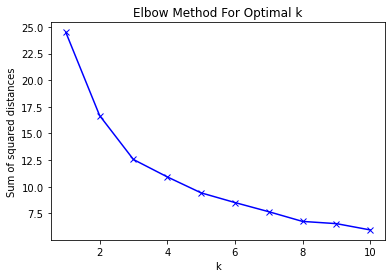

In [156]:
ss_dist = []
K = range(1, 11)
for k in K:
    km = cluster.KMeans(n_clusters=k, init='k-means++')
    km = km.fit(scaled_data)
    ss_dist.append(km.inertia_)
plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [157]:
nclusters = 4

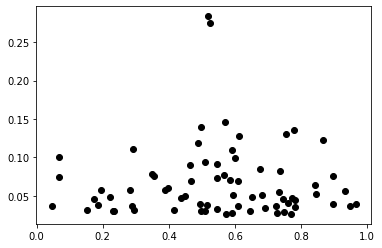

In [158]:
plt.scatter(X[:,0],X[:,1],c='black',label='unclustered data')

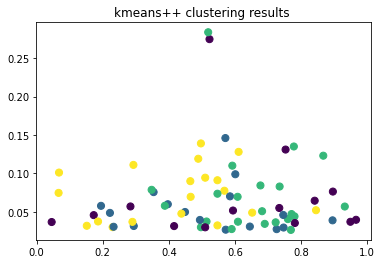

In [159]:
# Fitting K-Means to the dataset
model = cluster.KMeans(n_clusters = nclusters, init = 'k-means++')
model.fit(X)
y_pred = model.labels_
plt.title(f'kmeans++ clustering results ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_pred)

In [160]:
scaled_data

,valence,speechiness,instrumentalness,tempo,energy,key
0,0.652,0.0487,0.000661,0.420668,0.400,0.363636
1,0.966,0.0394,0.802000,0.190630,0.914,0.909091
2,0.735,0.0828,0.000003,0.421171,0.755,0.727273
3,0.747,0.0293,0.512000,0.302024,0.694,0.000000
4,0.547,0.0910,0.000040,0.384189,0.496,0.454545
...,...,...,...,...,...,...
67,0.592,0.1100,0.000022,0.457659,0.862,0.818182
68,0.608,0.0694,0.000016,0.385151,0.700,0.818182
69,0.510,0.0943,0.000000,0.210814,0.544,0.636364
70,0.195,0.0576,0.000000,0.585612,0.540,0.090909


In [161]:
playlist_track_data['kmeans++'] = y_pred

### spectral clustering

In [162]:
model = cluster.SpectralClustering(n_clusters = nclusters, eigen_solver='arpack',
        affinity="nearest_neighbors")

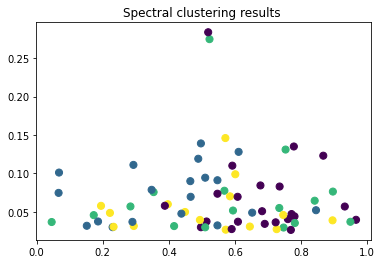

In [163]:
model.fit(X)
y_pred = model.labels_
plt.title(f'Spectral clustering results ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_pred)

In [164]:
playlist_track_data['spectral'] = y_pred

### birch clustering

In [165]:
model = cluster.Birch(n_clusters = nclusters)

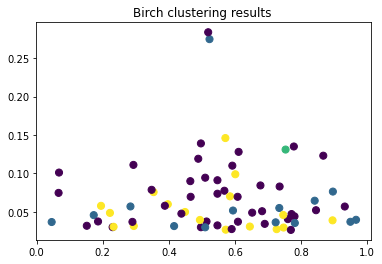

In [166]:
model.fit(X)
y_pred = model.labels_
plt.title(f'Birch clustering results ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_pred)

In [167]:
playlist_track_data['birch'] = y_pred

### mini batch kmeans

In [168]:
model = cluster.MiniBatchKMeans(n_clusters=nclusters)

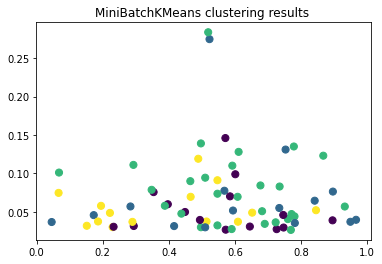

In [169]:
model.fit(X)
y_pred = model.labels_
plt.title(f'MiniBatchKMeans clustering results ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_pred)

In [170]:
playlist_track_data['minibatch'] = y_pred

In [171]:
playlist_track_data.head()

,id,name,artist,popularity,album_release_dt,explicit,danceability,energy,key,loudness,...,uri,track_href,analysis_url,duration_ms,time_signature,clusters,kmeans++,spectral,birch,minibatch
0,3X8gOyVXP93Tslnz9Bxw24,Gronlandic Edit,of Montreal,58,2007-01-23,False,0.971,0.400,4,-7.154,...,spotify:track:3X8gOyVXP93Tslnz9Bxw24,https://api.spotify.com/v1/tracks/3X8gOyVXP93T...,https://api.spotify.com/v1/audio-analysis/3X8g...,204760,4,0,3,1,0,3
1,5XcDorvZjj05UPeU4NY3nu,Old Graffiti,Bibio,53,2019-04-12,False,0.639,0.914,10,-7.189,...,spotify:track:5XcDorvZjj05UPeU4NY3nu,https://api.spotify.com/v1/tracks/5XcDorvZjj05...,https://api.spotify.com/v1/audio-analysis/5XcD...,208853,4,1,0,0,1,1
2,6VPvz8SZWRFEoawyUTvQTt,Everyone Acts Crazy Nowadays,Unknown Mortal Orchestra,51,2018-04-06,False,0.816,0.755,8,-4.942,...,spotify:track:6VPvz8SZWRFEoawyUTvQTt,https://api.spotify.com/v1/tracks/6VPvz8SZWRFE...,https://api.spotify.com/v1/audio-analysis/6VPv...,254973,4,0,2,0,0,2
3,2EWG2vhqHcPA3kDKf5337J,Tinseltown Swimming in Blood,Destroyer,46,2017-10-20,False,0.679,0.694,0,-7.375,...,spotify:track:2EWG2vhqHcPA3kDKf5337J,https://api.spotify.com/v1/tracks/2EWG2vhqHcPA...,https://api.spotify.com/v1/audio-analysis/2EWG...,286028,4,2,1,2,3,0
4,22fOsxYglRTjZcTOG8859P,Easy To Get,Hot Chip,48,2015-10-23,False,0.884,0.496,5,-7.738,...,spotify:track:22fOsxYglRTjZcTOG8859P,https://api.spotify.com/v1/tracks/22fOsxYglRTj...,https://api.spotify.com/v1/audio-analysis/22fO...,310295,4,0,3,1,0,3
